Una serie temporal es un conjunto de observaciones registradas en el tiempo.

Muchas veces, al analizar series temporales nuestro objetivo principal consiste en modelizar la serie, es decir, en construir un modelo que permita identificar y explicar un patrón de comportamiento a partir del cual realizar predicciones. Sin embargo, uno de los mayores problemas - si no el mayor - de esta disciplina estadística consiste en que no existe una sola forma de modelizar ni una técnica que sea la mejor en todos los casos. 

Específicamente, en este cuaderno, vamos a mostrar como pasar automáticamente de unos datos a un modelo ARIMA: a partir de una serie real, obtendremos un modelo ARIMA, analizaremos la bondad del ajuste del modelo y realizaremos una predicción. Todo ello, lo haremos con Python. Asimismo, explicaremos lo que son los modelos ARIMA sin entrar en muchos detalles sobre la especificación y estimación del modelo.

###**¿Qué son los modelos ARIMA?**

Los modelos ARIMA son modelos paramétricos que tratan de caracterizar la serie en base a la interrelación temporal de sus elementos.

Para explicar esto más pormenorizadamente debemos acudir al propio nombre: **ARIMA = Auto-Regressive Integrated Moving Average = Autorregresivo Integrado de Medias Móviles**. Es decir, los modelos ARIMA tienen una parte autorregresiva (AR), otra parte de medias móviles (MA) y están integrados (I). Los modelos autorregresivos y los de medias móviles los tratamos más a fondo en otro ***cuaderno***, pero de manera resumida consisten en:

* AR(p): un modelo **autorregresivo** de orden *p* expresa cada observación de la serie temporal en función de su pasado hasta el retardo (momento en el pasado) *p* y la pertubación/error en el momento *t*:
\begin{align}
Y_t = \phi_1Y_{t-1} + \phi_2Y_{t-2} +\ ... \ + \phi_pY_{t-p} + a_t \ \ \ \  con\ \ \ \  a_t \sim RB(0, \sigma^2)
\end{align}
$Y_t$: observación en el instante *t*, el momento presente.

  RB: Ruido Blanco: fluctuación aleatoria de la serie, con media cero, varianza constante y errores no correlacionados.
\begin{align}
\end{align}
* MA(q): un modelo de **medias móviles** de orden *q* expresa cada observación de la serie temporal en función de la perturbación en el momento *t* y del pasado de la perturbación hasta el retardo *q*:
\begin{align}
Y_t = a_t - \theta_1a_{t-1} - \theta_2a_{t-2} -\ ... \ - \theta_qa_{t-q}
\end{align}
\begin{align}
\end{align}
* I(d): un proceso estocástico (serie temporal) es integrado de orden *d* si no es estacionario pero su diferencia de orden *d* sigue un proceso ARMA estacionario e invertible. Así, el orden de integración del proceso, *d*, es el número de diferencias que hay que tomar para conseguir la estacionariedad en media. Las condiciones de estacionariedad e invertibilidad las tratamos en otro ***cuaderno***. La idea que nos debemos quedar en este caso es que *d* es el número de diferencias de la serie que debemos tomar para poder modelizar nuestros datos según la metodología ARIMA. Tomar una diferencia consiste en restar a cada observación, la observación anterior.

Por lo tanto, una serie que sigue un modelo $ARIMA(p,d,q)$ es aquella que es estacionaria en media (porque es integrada de orden *d*), tiene una parte autorregresiva (depende de las observaciones pasadas hasta el momento *p*) y otra de medias móviles (depende de la perturbación presente y de las pasadas hasta el momento *q*):
\begin{align}
\Delta^d Y_t = \phi_1Y_{t-1} + \phi_2Y_{t-2} +\ ... \ + \phi_pY_{t-p} \ \ +\ \  a_t - \theta_1a_{t-1} - \theta_2a_{t-2} -\ ... \ - \theta_qa_{t-q}
\end{align}
\begin{align}
\end{align}
En la actualidad, los modelos ARIMA llevan la denominación más genérica de SARIMAX (*Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors*), esto es, permiten la existencia de componentes estacionales y la incorporación de terceras variables al análisis. La componente estacional, que se explica en este otro **cuaderno**, puede tener sus propios parámetros *p*, *d* y *q*, pero, para diferenciarlos de los anteriores, los escribimos en mayúsucula. De esta forma, ampliamos el modelo a $SARIMAX(p,d,q)(P,D,Q)_s$ ($ _s$ es la periodicidad estacional: si la estacionalidad es trimestral: $ _s = 4$; si es mensual $ _s = 12$, etc.).


###**Metodología *Box-Jenquins***

La **metodología *Box-Jenquins*** es, probablemente, la metodología más utilizada para determinar el proceso ARIMA que ha podido generar una serie temporal. Dicha metodología está formada por cuatro etapas:
1. **Identificación** de los órdenes (*p*, *d*, *q*, *P*, *D*, *Q*) del modelo.
2. **Estimación** de los parámetros $\phi$ y $θ$ (mediante Mínimos Cuadrados o Máxima Verosimilitud).
3. **Validación** del modelo propuesto: realización de distintos contrastes de hipótesis para evaluar la adecuación de los modelos estimados a los datos. Principalmente,  se contrasta si: 1) las estimaciones de los coeficientes son significativas y cumplen las condiciones de estacionariedad e invertibilidad; y 2) si los residuos del modelos son ruido blanco.
4. **Predicción** en base al modelo validado.

Asimismo, esta metodología se basa, fundamentalmente, en dos principios:
* Selección del modelo de manera iterativa: suelen identificarse distintos modelos posibles siendo el que presenta un mejor ajuste a los datos el que finalmente se elija. Por ello, tras cada etapa es posible rehacer las etapas anteriores.
* Principio de parsimonia: ante dos o más modelos con un mismo ajuste, nos debemos quedar con aquel que tiene menor número de parámetros, es decir, con el modelo más sencillo posible.

En este cuaderno, aprovechando la potencialidad de Python, vamos a ajustar nuestros datos automáticamente a un modelo ARIMA mediante la función `auto_arima()` de la librería `pmdarima`. Esto implica que las etapas de identificación y estimación las realizará Python automáticamente, y desarrollaremos las etapas de validación y predicción.

###**Librerías a utilizar**

En este cuaderno vamos a emplear las siguientes librerías:

In [ ]:
#Librerías básicas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Librería que contiene la función auto_arima():
! pip install pmdarima
import pmdarima as pm
#Librería que contiene funciones importantes para el análisis de series temporales:
! pip install statsmodels --upgrade
from statsmodels.tsa.api import acf, graphics, pacf
#Para realizar contraste de que los residuos son igual a cero:
from scipy import stats
#Librería que contiene métricas para evaluar modelos que permitan realizar predicciones:
import sklearn.metrics as skmet

###**Datos**
Para ejemplificar cómo pasar de los datos a un modelo ARIMA vamos a utilizar tres ejemplos:
1. Serie de los datos del PIB a precios de mercado por la vía de la Demanda sin ajuste de estacionalidad y calendario. Periodicidad trimestral entre el primer trimestre de 1995 y el último de 2019.
2. Serie de los datos del PIB a precios de mercado por la vía de la Demanda ajustadas la estacionalidad y los efectos de calendario. Periodicidad trimestral entre el primer trimestre de 1995 y el último de 2019.
3. Serie de los datos del IPC (base 2021) de los Equipos audiovisuales, fotográficos y de procesamiento de información. Periodicidad mensual entre enero de 2002 y diciembre de 2021.

Los datos de PIB pueden obtenerse de este [enlace](https://ine.es/jaxiT3/Tabla.htm?t=30680&L=0) y los del IPC de este [otro](https://ine.es/jaxiT3/Tabla.htm?t=50903&L=0).

Una vez nos los hayamos descargado en formato *.csv* separado por **;** , los cargamos en el cuaderno de Colab de manera manual o a través de nuestra cuenta de Google Drive. En este [cuaderno](https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/Pildoras/Subir%20archivos%20a%20Colab%20desde%20repositorio%20local%20o%20Google%20Drive%20usando%20Python%20o%20R.ipynb) se explica cómo hacer la subida de datos a un cuaderno de Colab. En el presente cuaderno, subiremos los datos a través de Google Drive.

(Para facilitar el seguimiento del cuaderno hemos cambiado el nombre del *.csv* con los datos de PIB a **Datos_PIB**, y el *.csv* con los datos del IPC a **Datos_IPC_Tecnologia**).

Dicho esto, nos conectamos a Google Drive:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Leemos el archivo con los datos de PIB:

In [ ]:
import pandas as pd
datos_PIB = pd.read_csv("/content/drive/MyDrive/Datos_PIB.csv", sep=";", decimal=",", engine="python",  encoding="latin-1")
#Las opciones engine = "python" y encoding = "latin-1" las utilizamos para evitar un problema relacionado con la codificación UTF-8
datos_PIB = datos_PIB[["Tipo de dato", "Periodo", "Total"]]
#Nos quedamos solamente con las columnas más relevantes
datos_PIB = datos_PIB.rename(columns={"Total": "PIB(Millones_de_euros)"}) # Cambiamos el nombre de la columna "Total" a "Tasa_Paro"
print(datos_PIB.head())
print("-----------------------------------------------")
print(datos_PIB.tail())

                                        Tipo de dato Periodo  \
0  Datos no ajustados de estacionalidad y calendario  2019T4   
1  Datos no ajustados de estacionalidad y calendario  2019T3   
2  Datos no ajustados de estacionalidad y calendario  2019T2   
3  Datos no ajustados de estacionalidad y calendario  2019T1   
4  Datos no ajustados de estacionalidad y calendario  2018T4   

   PIB(Millones_de_euros)  
0                 324.228  
1                 305.611  
2                 315.507  
3                 299.029  
4                 314.974  
-----------------------------------------------
                                       Tipo de dato Periodo  \
195  Datos ajustados de estacionalidad y calendario  1996T1   
196  Datos ajustados de estacionalidad y calendario  1995T4   
197  Datos ajustados de estacionalidad y calendario  1995T3   
198  Datos ajustados de estacionalidad y calendario  1995T2   
199  Datos ajustados de estacionalidad y calendario  1995T1   

     PIB(Millones_de

In [ ]:
print("El número de filas del dataframe datos_PIB es", datos_PIB.shape[0], " y el de columnas es", datos_PIB.shape[1])

El número de filas del dataframe datos_PIB es 200  y el de columnas es 3


Si nos fijamos en la columna `Tipo de dato`, vemos que las primeras observaciones/filas contienen los datos de PIB **NO** ajustados a la estacionalidad y a posibles efectos de calendario, mientras que las últimas contienen los datos **SÍ** ajustados. Por ello, debemos dividir este `dataframe` en dos, para tener, por un lado, los datos no ajustados y, por otro, los ajustados:

In [ ]:
#Para el dataframe con los datos del PIB NO ajustados, nos vamos a quedar con aquellas filas que en la columna "Tipo de dato" ponga "Datos no ajustados de estacionalidad y calendario":
datos_PIB_NO_ajustados = datos_PIB[datos_PIB["Tipo de dato"] == "Datos no ajustados de estacionalidad y calendario"]
#Ordenamos las filas cronológicamente:
datos_PIB_NO_ajustados = datos_PIB_NO_ajustados.sort_values(["Periodo"])
#Creamos una nueva variable temporal que será el índice de nuestro dataframe:
datos_PIB_NO_ajustados["Trimestre"] = pd.date_range(start="1/1/1995", #Comienzo de la nueva variable temporal
                                                    periods=len(datos_PIB_NO_ajustados), #Número de periodos de la nueva variable temporal
                                                    freq="Q") #Frecuencia de la nueva variable temporal. En este caso, "Q" igual a "Trimestres"
datos_PIB_NO_ajustados.set_index("Trimestre", inplace=True) 
datos_PIB_NO_ajustados.head()

,Tipo de dato,Periodo,PIB(Millones_de_euros)
Trimestre,,,
1995-03-31,Datos no ajustados de estacionalidad y calendario,1995T1,109.165
1995-06-30,Datos no ajustados de estacionalidad y calendario,1995T2,116.633
1995-09-30,Datos no ajustados de estacionalidad y calendario,1995T3,112.398
1995-12-31,Datos no ajustados de estacionalidad y calendario,1995T4,122.392
1996-03-31,Datos no ajustados de estacionalidad y calendario,1996T1,115.776


In [ ]:
print("El número de filas del dataframe datos_PIB es", datos_PIB_NO_ajustados.shape[0], " y el de columnas es", datos_PIB_NO_ajustados.shape[1])

El número de filas del dataframe datos_PIB es 100  y el de columnas es 3


In [ ]:
#Para el dataframe con los datos del PIB NO ajustados, nos vamos a quedar con aquellas filas que en la columna "Tipo de dato" ponga "Datos ajustados de estacionalidad y calendario":
datos_PIB_SI_ajustados = datos_PIB[datos_PIB["Tipo de dato"] == "Datos ajustados de estacionalidad y calendario"]
#Ordenamos las filas cronológicamente:
datos_PIB_SI_ajustados = datos_PIB_SI_ajustados.sort_values(["Periodo"])
#Creamos una nueva variable temporal que será el índice de nuestro dataframe:
datos_PIB_SI_ajustados["Trimestre"] = pd.date_range(start="1/1/1995", #Comienzo de la nueva variable temporal
                                                    periods=len(datos_PIB_SI_ajustados), #Número de periodos de la nueva variable temporal
                                                    freq="Q") #Frecuencia de la nueva variable temporal. En este caso, "Q" igual a "Trimestres"
datos_PIB_SI_ajustados.set_index("Trimestre", inplace=True) 
datos_PIB_SI_ajustados.head()

,Tipo de dato,Periodo,PIB(Millones_de_euros)
Trimestre,,,
1995-03-31,Datos ajustados de estacionalidad y calendario,1995T1,112.760
1995-06-30,Datos ajustados de estacionalidad y calendario,1995T2,114.401
1995-09-30,Datos ajustados de estacionalidad y calendario,1995T3,115.628
1995-12-31,Datos ajustados de estacionalidad y calendario,1995T4,117.799
1996-03-31,Datos ajustados de estacionalidad y calendario,1996T1,119.460


In [ ]:
print("El número de filas del dataframe datos_PIB es", datos_PIB_SI_ajustados.shape[0], " y el de columnas es", datos_PIB_SI_ajustados.shape[1])

El número de filas del dataframe datos_PIB es 100  y el de columnas es 3


Ahora leemos el archivo con los datos del IPC. En este caso, no habría que dividir el `dataframe`, pero sí repetimos el procedimiento anterior, por ejemplo, en cuanto a la creación de un índice temporal:

In [ ]:
datos_IPC_Tecnologia = pd.read_csv("/content/drive/MyDrive/Datos_IPC_Tecnologia.csv", sep=";", decimal=",", engine="python",  encoding="latin-1")
#Las opciones engine = "python" y encoding = "latin-1" las utilizamos para evitar un problema relacionado con la codificación UTF-8
datos_IPC_Tecnologia = datos_IPC_Tecnologia[["Periodo", "Total"]]
#Nos quedamos solamente con las columnas más relevantes
datos_IPC_Tecnologia = datos_IPC_Tecnologia.rename(columns={"Total": "IPC_Tecnologia"}) # Cambiamos el nombre de la columna "Total" a "Tasa_Paro"
#Ordenamos los datos cronológicamente:
datos_IPC_Tecnologia = datos_IPC_Tecnologia.sort_values(["Periodo"])
#Creamos una nueva variable temporal que será el índice de nuestro dataframe:
datos_IPC_Tecnologia["Meses"] = pd.date_range(start="1/1/2002", #Comienzo de la nueva variable temporal
                                              periods=len(datos_IPC_Tecnologia), #Número de periodos de la nueva variable temporal
                                              freq="MS") #Frecuencia de la nueva variable temporal. En este caso, "M" igual a "Meses"
datos_IPC_Tecnologia.set_index("Meses", inplace=True) 
datos_IPC_Tecnologia.head()

,Periodo,IPC_Tecnologia
Meses,,
2002-01-01,2002M01,493.091
2002-02-01,2002M02,490.112
2002-03-01,2002M03,487.236
2002-04-01,2002M04,484.317
2002-05-01,2002M05,477.891


###**Ajustar un modelo ARIMA automáticamente**

Una vez hemos cargado todos los datos, vamos a proceder al ajuste automático a modelos ARIMA de las tres series temporales:

####**Serie temporal PIB con datos NO ajustados**

######**Creamos una serie temporal a partir de los datos**

Vamos a dividir nuestra serie temporal en dos conjuntos de datos: `entrenamiento` y `test`. El primero nos servirá para "entrenar" el modelo y realizar la predicción de 2019, e irá hasta diciembre de 2018; y el segundo, formado por los datos de 2019, nos permitirá comparar los datos reales de ese año con los predichos:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 96):
entrenamiento_datos_PIB_NO_ajustados_hasta_2018 = datos_PIB_NO_ajustados[:96]
#Datos de 2019 (a partir de la fila 97):
test_datos_PIB_NO_ajustados_2019 = datos_PIB_NO_ajustados[96:]

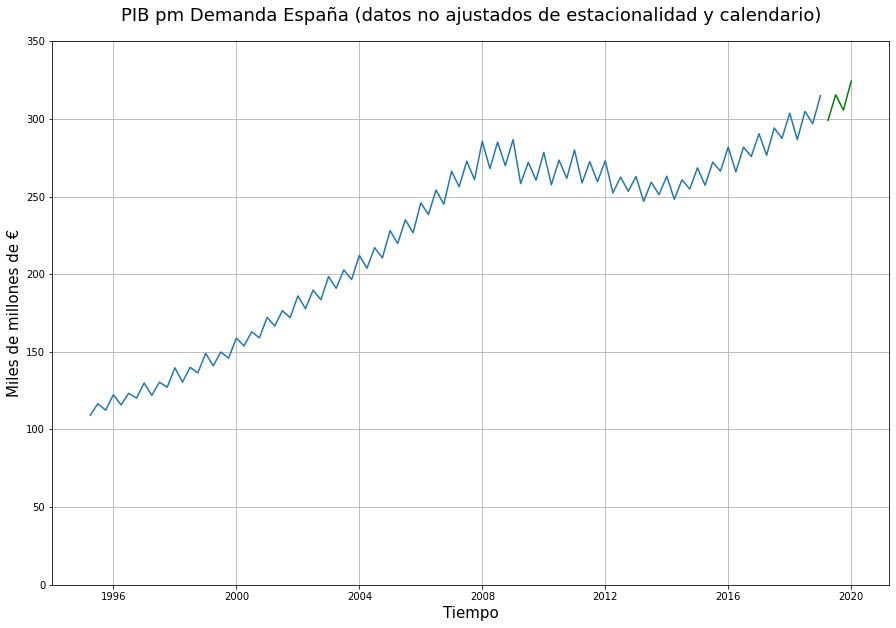

In [ ]:
#Seleccionamos la serie:
Serie_PIB_NO_ajustado = entrenamiento_datos_PIB_NO_ajustados_hasta_2018[["PIB(Millones_de_euros)"]]

#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_PIB_NO_ajustado)
plt.plot(test_datos_PIB_NO_ajustados_2019[["PIB(Millones_de_euros)"]], c="g")

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos no ajustados de estacionalidad y calendario)",
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
ax.set_ylim([0, 350]); #Rango de posibles valores del Eje Y


Vemos que la serie presenta estacionalidad, ya que parece seguir un patrón similar de subidas y bajadas todos los años. Entonces, como nuestros datos tenían periodicidad trimestral, diremos que la estacionalidad de la serie también es trimestral.

######**Utilizamos `auto_arima()`**

In [ ]:
ARIMA_Serie_PIB_NO_ajustado = pm.auto_arima(Serie_PIB_NO_ajustado,
                                            trace=True, #Para que nos salga todo el proceso que realiza internamente
                                            seasonal=True, #Especificamos que tiene estacionalidad
                                            m=4) #Periodicidad de la estacionalidad. En este caso, trimestral

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=425.565, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=433.787, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=437.099, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=437.394, Time=0.05 sec
 ARIMA(2,1,2)(0,1,1)[4]             : AIC=426.962, Time=0.21 sec
 ARIMA(2,1,2)(1,1,0)[4]             : AIC=427.943, Time=0.20 sec
 ARIMA(2,1,2)(2,1,1)[4]             : AIC=427.358, Time=0.86 sec
 ARIMA(2,1,2)(1,1,2)[4]             : AIC=427.317, Time=0.76 sec
 ARIMA(2,1,2)(0,1,0)[4]             : AIC=425.674, Time=0.14 sec
 ARIMA(2,1,2)(0,1,2)[4]             : AIC=427.523, Time=0.32 sec
 ARIMA(2,1,2)(2,1,0)[4]             : AIC=428.090, Time=0.31 sec
 ARIMA(2,1,2)(2,1,2)[4]             : AIC=428.846, Time=0.63 sec
 ARIMA(1,1,2)(1,1,1)[4]             : AIC=427.085, Time=0.36 sec
 ARIMA(2,1,1)(1,1,1)[4]             : AIC=423.863, Time=0.27 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=425.2

In [ ]:
#Mostramos el AIC del modelo:
ARIMA_Serie_PIB_NO_ajustado.aic()

423.8632005602259

`auto_arima()` se queda con el modelo que minimiza el AIC (*Akaike Information Criteria*, un índice de bondad del ajuste de los datos al modelo)

In [ ]:
print(ARIMA_Serie_PIB_NO_ajustado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   96
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -205.932
Date:                           Mon, 27 Jun 2022   AIC                            423.863
Time:                                   15:29:13   BIC                            438.928
Sample:                                        0   HQIC                           429.941
                                            - 96                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3863      0.167     -2.316      0.021      -0.713      -0.059
ar.L2          0.4234      0.071      5.957

Según `auto_arima()` el modelo que mejor ajusta a los datos es un $ARIMA(2,1,1)(1,1,1)_4$:
\begin{align}
Δ^1_4Y_t = -0,3863Y_{t-1}+0,4234Y_{t-2}+a_t+0,4638a_{t-1}+0,6404Y_{t-4}-0,8840a_{t-4}
\end{align}

Si atendemos a los $p-valores$ de los coeficientes, podemos considerar que todos son estadísticamente significativos ya son mayores al nivel de significación $\alpha=0,05$.


######**Estudiamos los residuos**

El siguiente paso consiste en estudiar si los residuos se distruyen como ruido blanco (independientes, heterocedásticos y con media cero). Para ello, volvemos a mostrar los resultados de nuestro modelo:

In [ ]:
print(ARIMA_Serie_PIB_NO_ajustado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   96
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -205.932
Date:                           Mon, 27 Jun 2022   AIC                            423.863
Time:                                   15:35:22   BIC                            438.928
Sample:                                        0   HQIC                           429.941
                                            - 96                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3863      0.167     -2.316      0.021      -0.713      -0.059
ar.L2          0.4234      0.071      5.957

Miremos ahora a los contrastes de hipótesis que nos muestra la tabla:
* Test de Ljung-Box: $p-valor = 0,92 > 0,05$, por lo tanto, no podemos rechazar la hipótesis nula de independencia (no correlación) de los residuos.
* Test de Homocedasticidad: $p-valor = 0,00 < 0,05$, es decir, los residuos son heterocedásticos (no tienen igual varianza).
* Test de Jarque-Bera: $p-valor = 0,00 < 0,05$, esto es, los residuos no se distribuyen normalmente.

In [ ]:
#Media de los residuos:
ARIMA_Serie_PIB_NO_ajustado.resid().mean()

0.6547819397948053

In [ ]:
#Test de la t para contrastar que la media de los residuos es cero:
stats.ttest_1samp(ARIMA_Serie_PIB_NO_ajustado.resid(), 0)

Ttest_1sampResult(statistic=0.4900625966156107, pvalue=0.6252194741131711)

Como $p-valor = 0,6252 > 0,05$, no podemos rechazar la hipótesis nula de que la media de los residuos es igual a cero.

Entonces, teniendo en cuenta este hecho y los resultados de los contrastes de hipótesis, no podemos considerar que los residuos de nuestro modelo se distribuyan como ruido blanco, pues su varianza no es constante.

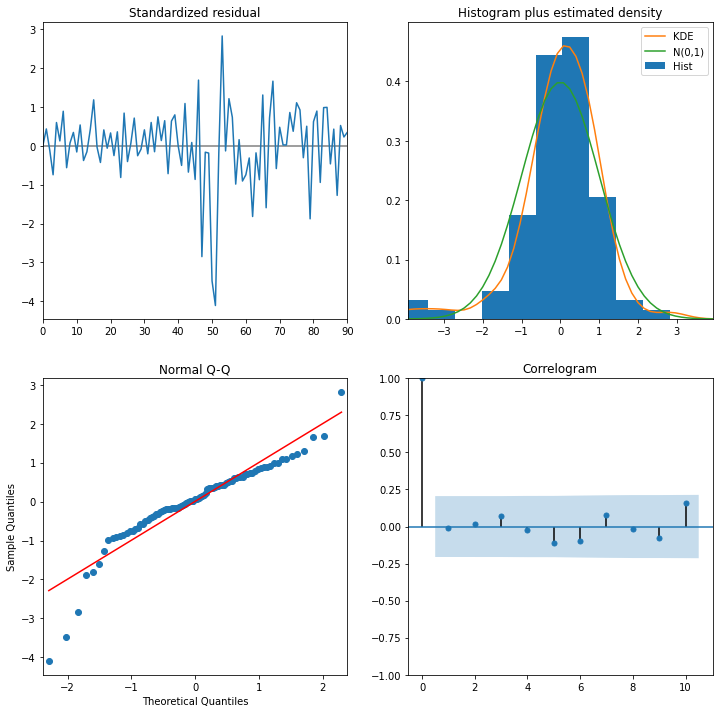

In [ ]:
Graficos = ARIMA_Serie_PIB_NO_ajustado.plot_diagnostics(figsize=(12,12))

Los gráficos de los residuos refuerzan la idea anterior:
* Arriba a la izquierda: los residuos no parecen fluctuar con varianza uniforme en torno a una media de cero.
* Arriba a la derecha: el gráfico de densidad sugiere que los residuos no se distribuyen como una $N(0, 1)$.
* Abajo a la izquierda: la mayoría de los puntos no se encuentran sobre la línea, lo que también indica que su distribución se asemeja mucho a la Normal.
* Abajo a la derecha: correlograma, no hay ninguna correlación residual significativa. Por lo tanto, se refuerza el resultado del test de Ljung-Box, y podemos considerar que los residuos son independientes.

######**Predecimos el siguiente año**


El último paso o la motivación última del análisis de series temporales suele ser la predicción de valores futuros. En este caso, no vamos a predecir valores futuros, sino que vamos a predecir el año 2019 para luego poder comparar la predicción con los valores reales (guardados en el conjunto de `test`) y estudiar la bondad de ajuste del modelo:

In [ ]:
#Predecimos el 2019 (4 trimestres) y el intervalo de confianza al 95% de las predicciones:
prediccion_2019_PIB_NO_ajustado, confint_2019_PIB_NO_ajustado = ARIMA_Serie_PIB_NO_ajustado.predict(n_periods = 4,  return_conf_int=True)
prediccion_2019_PIB_NO_ajustado = pd.DataFrame(prediccion_2019_PIB_NO_ajustado, index=test_datos_PIB_NO_ajustados_2019.index)
confint_2019_PIB_NO_ajustado = pd.DataFrame(confint_2019_PIB_NO_ajustado, index=test_datos_PIB_NO_ajustados_2019.index)
prediccion_2019_PIB_NO_ajustado = pd.concat([prediccion_2019_PIB_NO_ajustado, confint_2019_PIB_NO_ajustado], axis=1)
prediccion_2019_PIB_NO_ajustado.columns = [["Valores_Predichos", "Confint_Inferior", "Confint_Superior"]]
prediccion_2019_PIB_NO_ajustado

,Valores_Predichos,Confint_Inferior,Confint_Superior
Trimestre,,,
2019-03-31,297.668776,293.149765,302.187787
2019-06-30,316.084692,309.441855,322.727528
2019-09-30,307.338796,297.941455,316.736137
2019-12-31,325.536760,314.328709,336.744810


Graficamos la serie real, la predicción y su intervalo de confianza:

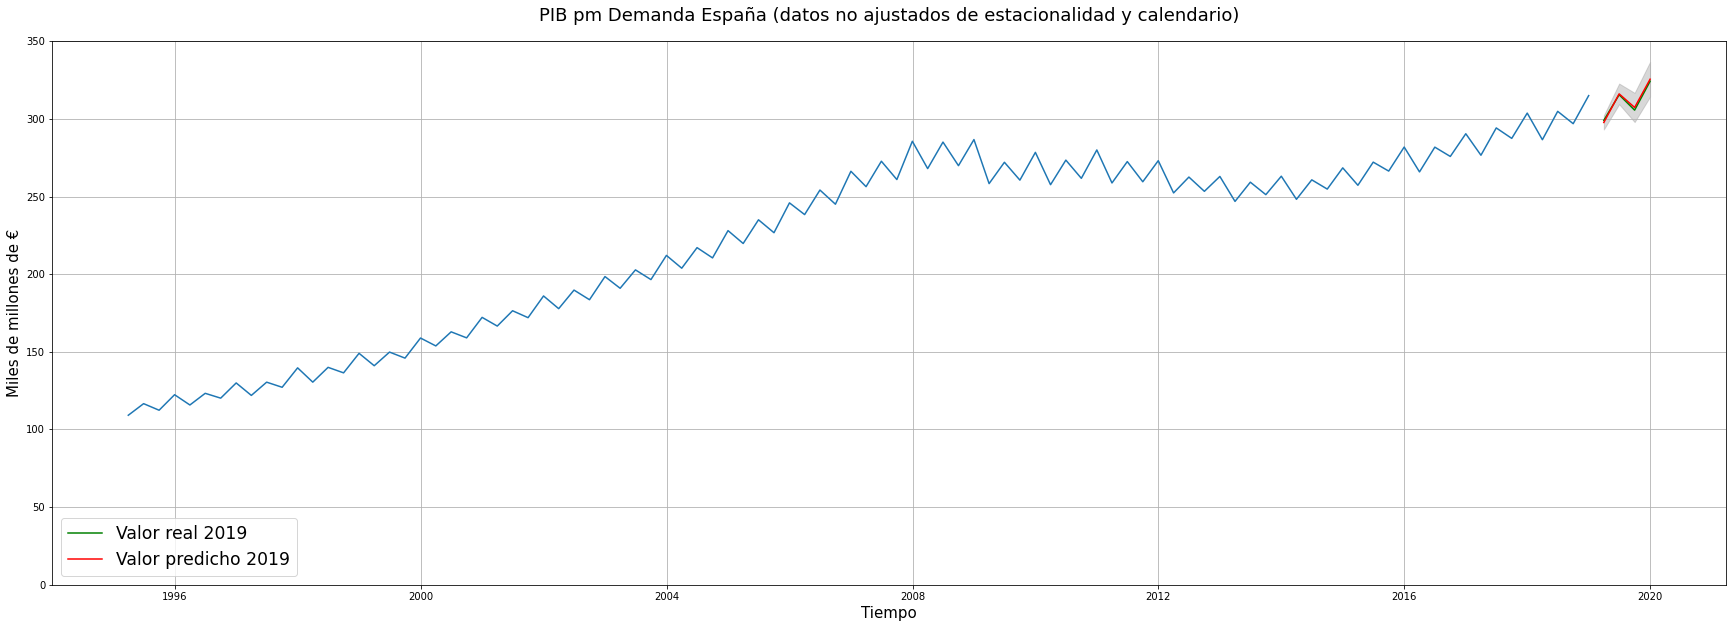

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_PIB_NO_ajustado)
plt.plot(test_datos_PIB_NO_ajustados_2019[["PIB(Millones_de_euros)"]], label="Valor real 2019", c="g")
plt.plot(prediccion_2019_PIB_NO_ajustado["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2019_PIB_NO_ajustado.index,
                confint_2019_PIB_NO_ajustado[0],
                confint_2019_PIB_NO_ajustado[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos no ajustados de estacionalidad y calendario)",
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
ax.set_ylim([0, 350]); #Rango de posibles valores del Eje Y
plt.legend(loc="lower left", fontsize="xx-large");

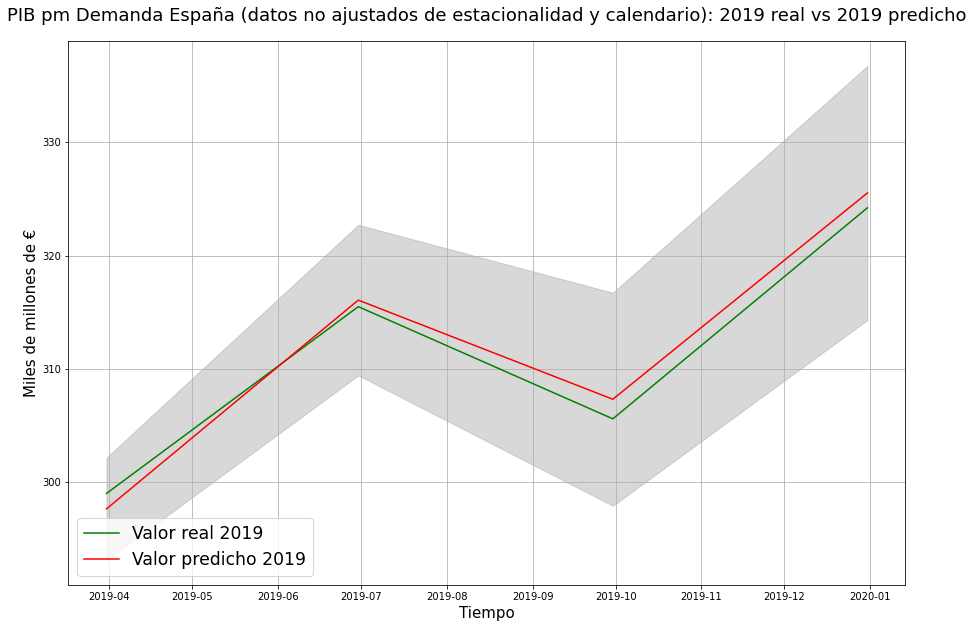

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(test_datos_PIB_NO_ajustados_2019[["PIB(Millones_de_euros)"]], label="Valor real 2019", c="g")
plt.plot(prediccion_2019_PIB_NO_ajustado["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2019_PIB_NO_ajustado.index,
                confint_2019_PIB_NO_ajustado[0],
                confint_2019_PIB_NO_ajustado[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos no ajustados de estacionalidad y calendario): 2019 real vs 2019 predicho",
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
plt.legend(loc="lower left", fontsize="xx-large");

####**Serie temporal PIB con datos SÍ ajustados**


Repetimos todo el procedimiento anterior con la serie temporal del PIB con los datos ajustados a la estacionalidad y posibles efectos de calendario.

En primer lugar, volvemos a hacer la división entre conjunto de datos de entrenamiento y conjunto de test:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 96):
entrenamiento_datos_PIB_SI_ajustados_hasta_2018 = datos_PIB_SI_ajustados[:96]
#Datos de 2019 (a partir de la fila 97):
test_datos_PIB_SI_ajustados_2019 = datos_PIB_SI_ajustados[96:]

Graficamos la serie temporal:

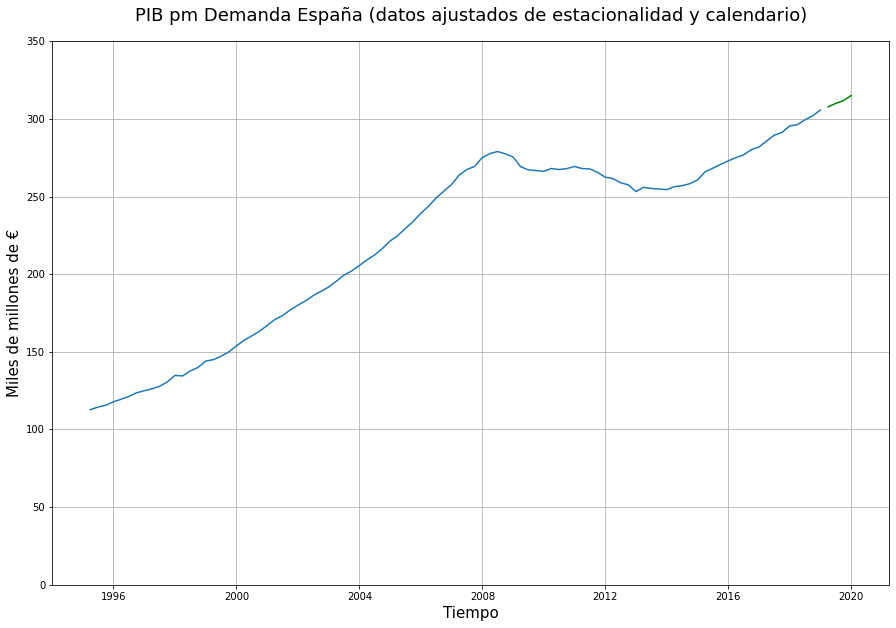

In [ ]:
#Seleccionamos la serie:
Serie_PIB_SI_ajustado = entrenamiento_datos_PIB_SI_ajustados_hasta_2018[["PIB(Millones_de_euros)"]]

#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_PIB_SI_ajustado)
plt.plot(test_datos_PIB_SI_ajustados_2019[["PIB(Millones_de_euros)"]], c="g")

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos ajustados de estacionalidad y calendario)", #IMPORTANTE: como no vamos a mostrar solo un mapa, el título debe ir cambiando conforme vamos utilizando nuestro widget
                  pad = 20, #Eleva el título, separándolo del contorno de la figura
                  fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
ax.set_ylim([0, 350]); #Rango de posibles valores del Eje Y;

Empleamos `auto_arima()`:

In [ ]:
ARIMA_Serie_PIB_SI_ajustado = pm.auto_arima(Serie_PIB_SI_ajustado,
                                            trace=True, #Para que nos salga todo el proceso que realiza internamente
                                            seasonal=True, #Especificamos que tiene estacionalidad
                                            m=4) #Periodicidad de la estacionalidad. En este caso, trimestral

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=365.903, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=428.533, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=374.424, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=390.934, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=482.767, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=364.210, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=363.000, Time=0.19 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=364.110, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=361.022, Time=0.09 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=362.110, Time=0.21 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=362.211, Time=0.15 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=363.907, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=384.447, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=362.909, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=363.0

Aunque los datos han sido ajustado por el INE a la estacionalidad, es decir, han quitado la estacionalidad, a `auto.arima()` le decimos `seasonal=True` para poder decirle que la periodicidad (`m`) es trimestral. Sino, no podemos usar dicho argumento `m`.

In [ ]:
#Mostramos el AIC del modelo:
ARIMA_Serie_PIB_SI_ajustado.aic()

361.0215330386524

In [ ]:
print(ARIMA_Serie_PIB_SI_ajustado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -175.511
Date:                Mon, 27 Jun 2022   AIC                            361.022
Time:                        16:02:43   BIC                            373.791
Sample:                             0   HQIC                           366.181
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2981      0.162      1.843      0.065      -0.019       0.615
ar.L1          0.8566      0.070     12.180      0.000       0.719       0.994
ma.L1         -0.5164      0.105     -4.938      0.0

En este caso, el modelo que arroja `auto_arima()` no tiene coeficientes estacionales, ya que los datos están ajustados a la estacionalidad. Lo que sí presenta este modelo es un intercepto. El modelo es un $ARIMA(1,1,2)$:
\begin{align}
\Delta^1Y=0,2981+0,8566Y_{t-1}+a_t-0,5165a_{t-1}+0,2244a_{t-2}
\end{align}

No obstante, el intercepto solo es significativo al 90%. Por lo tanto, para ver si ajusta mejor un modelo con o sin intercepto, vamos a ajustar los datos al mismo modelo, pero sin intercepto. Para ello, empleamos la función `arima.ARIMA`:

In [ ]:
#Creamos el modelo sin intercepto:
Segundo_ARIMA_Serie_PIB_SI_ajustado = pm.arima.ARIMA(order = (1,1,2),
                                                        seasonal_order = (0,0,0,0),
                                                        with_intercept = False)
#Ajustamos los datos al modelo sin intercepto:
Segundo_ARIMA_Serie_PIB_SI_ajustado = Segundo_ARIMA_Serie_PIB_SI_ajustado.fit(Serie_PIB_SI_ajustado)
#Obtenemos el AIC de dicho modelo:
Segundo_ARIMA_Serie_PIB_SI_ajustado.aic()

363.2065765969046

Como el AIC del modelo sin intercepto es superior al modelo con, nos quedamos con el modelo con intercepto.

A continuación, pasamos a estudiar los residuos:

In [ ]:
print(ARIMA_Serie_PIB_SI_ajustado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -175.511
Date:                Mon, 27 Jun 2022   AIC                            361.022
Time:                        16:11:41   BIC                            373.791
Sample:                             0   HQIC                           366.181
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2981      0.162      1.843      0.065      -0.019       0.615
ar.L1          0.8566      0.070     12.180      0.000       0.719       0.994
ma.L1         -0.5164      0.105     -4.938      0.0

* Test de Ljung-Box: $p-valor = 0,96 > 0,05$, por lo tanto, no podemos rechazar la hipótesis nula de independencia (no correlación) de los residuos.
* Test de Homocedasticidad: $p-valor = 0,02 < 0,05$, es decir, los residuos son heterocedásticos (no tienen igual varianza).
* Test de Jarque-Bera: $p-valor = 0,00 < 0,05$, esto es, los residuos no se distribuyen normalmente.

In [ ]:
#Media de los residuos:
ARIMA_Serie_PIB_SI_ajustado.resid().mean()

1.161495257011477

In [ ]:
#Test de la t para contrastar que la media de los residuos es cero:
stats.ttest_1samp(ARIMA_Serie_PIB_SI_ajustado.resid(), 0)

Ttest_1sampResult(statistic=0.9984212451734084, pvalue=0.3206114748502371)

Como $p-valor = 0,3206 > 0,05$, no podemos rechazar la hipótesis nula de que la media de los residuos es igual a cero.

Entonces, teniendo en cuenta este hecho y los resultados de los contrastes de hipótesis, no podemos considerar que los residuos de nuestro modelo se distribuyan como ruido blanco, pues su varianza no es constante.

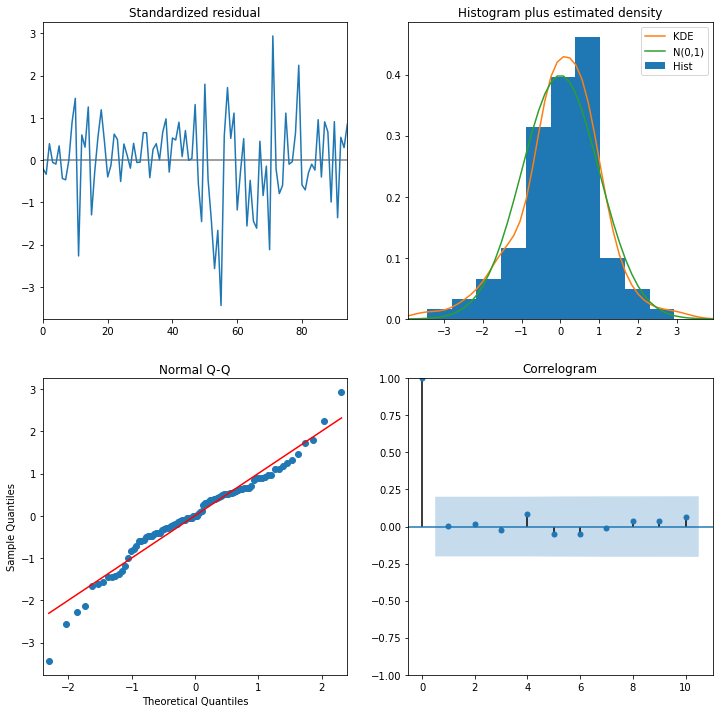

In [ ]:
Graficos = ARIMA_Serie_PIB_SI_ajustado.plot_diagnostics(figsize=(12,12))

Los gráficos de los residuos refuerzan la idea anterior:
* Arriba a la izquierda: los residuos no parecen fluctuar con varianza uniforme en torno a una media de cero.
* Arriba a la derecha: el gráfico de densidad sugiere que los residuos no se distribuyen como una $N(0, 1)$.
* Abajo a la izquierda: la mayoría de los puntos no se encuentran sobre la línea, lo que también indica que su distribución se asemeja mucho a la normal.
* Abajo a la derecha: correlograma, no hay ninguna correlación residual significativa. Por lo tanto, se refuerza el resultado del test de Ljung-Box, y podemos considerar que los residuos son independientes.

Revisadas las series temporales del PIB (ajustado o no), en ningún caso los residuos son homocedásticos (varianza constante). Y si atendemos al gráfico de los residuos y al gráfico de la serie podemos considerar que dicha falta de homocedasticidad se debe al shock que supuso la crisis iniciada en 2008

Finalmente, realizamos la predicción de 2019 y su comparación con los datos reales de ese año:

In [ ]:
#Predecimos el 2019 (4 trimestres) y el intervalo de confianza al 95% de las predicciones:
prediccion_2019_PIB_SI_ajustado, confint_2019_PIB_SI_ajustado = ARIMA_Serie_PIB_SI_ajustado.predict(n_periods = 4,  return_conf_int=True)
prediccion_2019_PIB_SI_ajustado = pd.DataFrame(prediccion_2019_PIB_SI_ajustado, index=test_datos_PIB_SI_ajustados_2019.index)
confint_2019_PIB_SI_ajustado = pd.DataFrame(confint_2019_PIB_SI_ajustado, index=test_datos_PIB_SI_ajustados_2019.index)
prediccion_2019_PIB_SI_ajustado = pd.concat([prediccion_2019_PIB_SI_ajustado, confint_2019_PIB_SI_ajustado], axis=1)
prediccion_2019_PIB_SI_ajustado.columns = [["Valores_Predichos", "Confint_Inferior", "Confint_Superior"]]
prediccion_2019_PIB_SI_ajustado

,Valores_Predichos,Confint_Inferior,Confint_Superior
Trimestre,,,
2019-03-31,308.646390,305.653159,311.639621
2019-06-30,311.756102,306.750755,316.761449
2019-09-30,314.718061,307.240072,322.196051
2019-12-31,317.553451,307.393055,327.713846


Graficamos la serie real, la predicción y su intervalo de confianza:

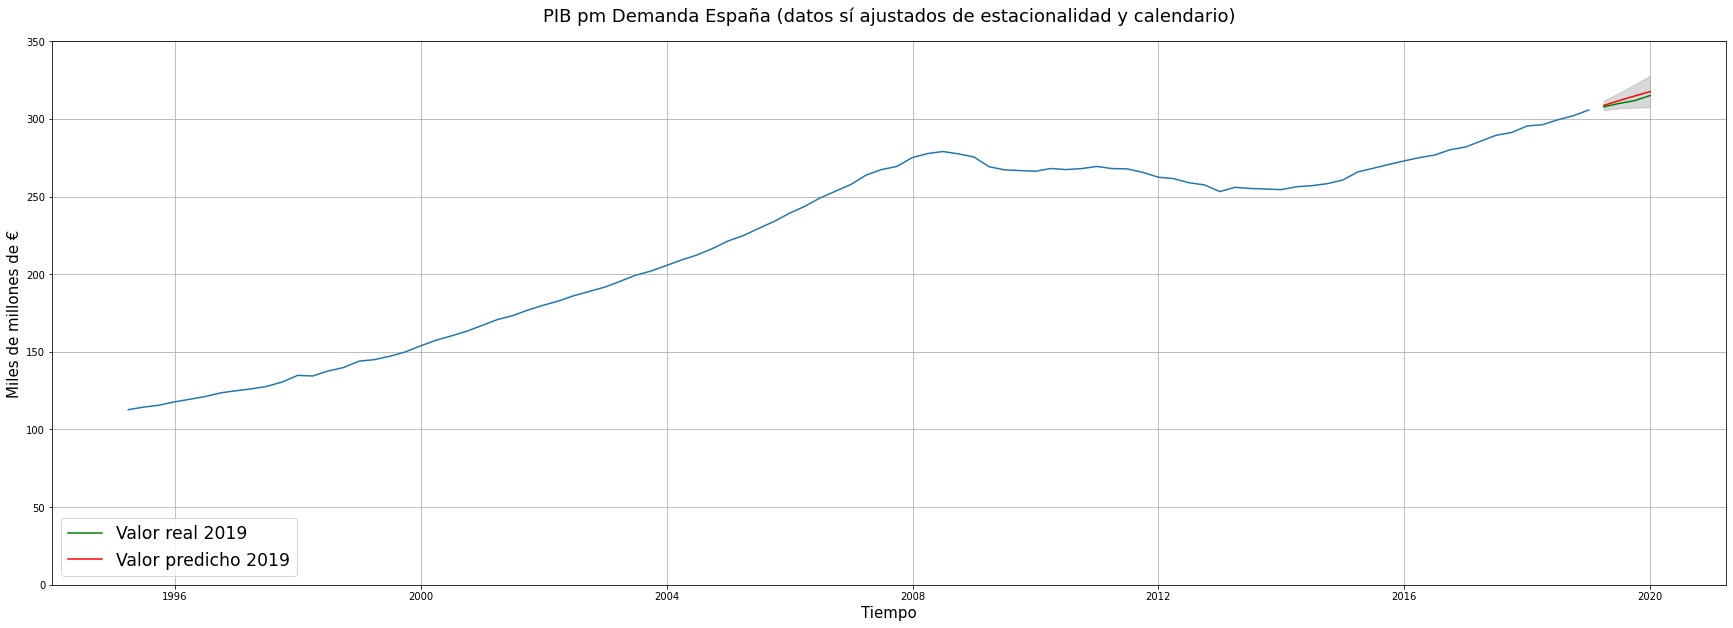

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_PIB_SI_ajustado)
plt.plot(test_datos_PIB_SI_ajustados_2019[["PIB(Millones_de_euros)"]], label="Valor real 2019", c="g")
plt.plot(prediccion_2019_PIB_SI_ajustado["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2019_PIB_SI_ajustado.index,
                confint_2019_PIB_SI_ajustado[0],
                confint_2019_PIB_SI_ajustado[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos sí ajustados de estacionalidad y calendario)",
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
ax.set_ylim([0, 350]); #Rango de posibles valores del Eje Y
plt.legend(loc="lower left", fontsize="xx-large");

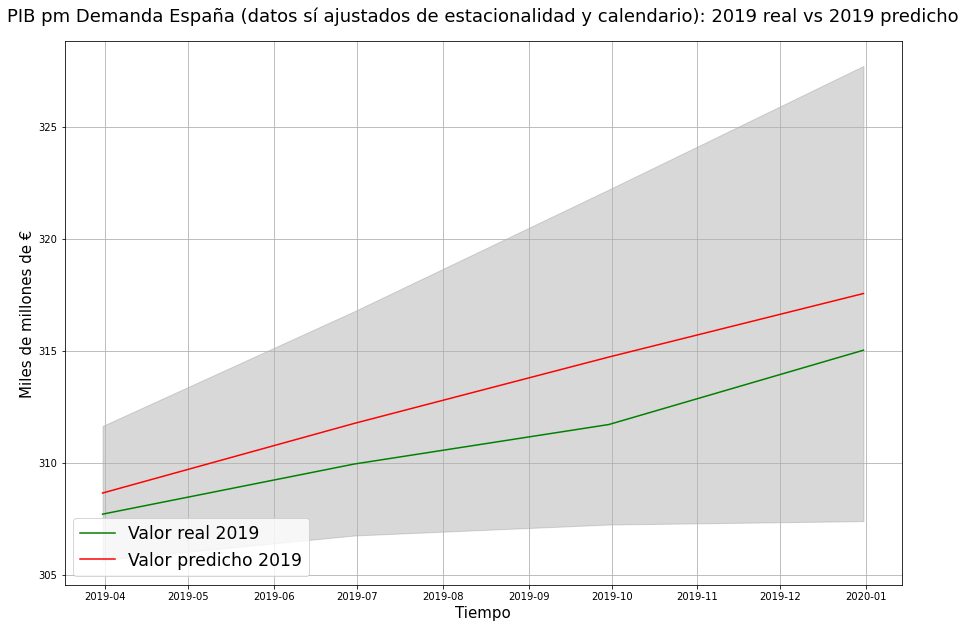

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(test_datos_PIB_SI_ajustados_2019[["PIB(Millones_de_euros)"]], label="Valor real 2019", c="g")
plt.plot(prediccion_2019_PIB_SI_ajustado["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2019_PIB_SI_ajustado.index,
                confint_2019_PIB_SI_ajustado[0],
                confint_2019_PIB_SI_ajustado[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("PIB pm Demanda España (datos sí ajustados de estacionalidad y calendario): 2019 real vs 2019 predicho",
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Miles de millones de €", fontsize=15)
plt.legend(loc="lower left", fontsize="xx-large");

Como ocurría con los datos no ajustados, los valores predichos son superiores a los reales.

####**Serie temporal IPC Tecnología**

Y repetimos, de nuevo, el proceso con los datos del IPC:

In [ ]:
#Datos hasta 2018 incluido (hasta la fila 228):
entrenamiento_datos_IPC_Tecnologia_hasta_2020 = datos_IPC_Tecnologia[:228]
#Datos de 2019 (a partir de la fila 229):
test_datos_IPC_Tecnologia_2021 = datos_IPC_Tecnologia[228:]

Graficamos la serie temporal:

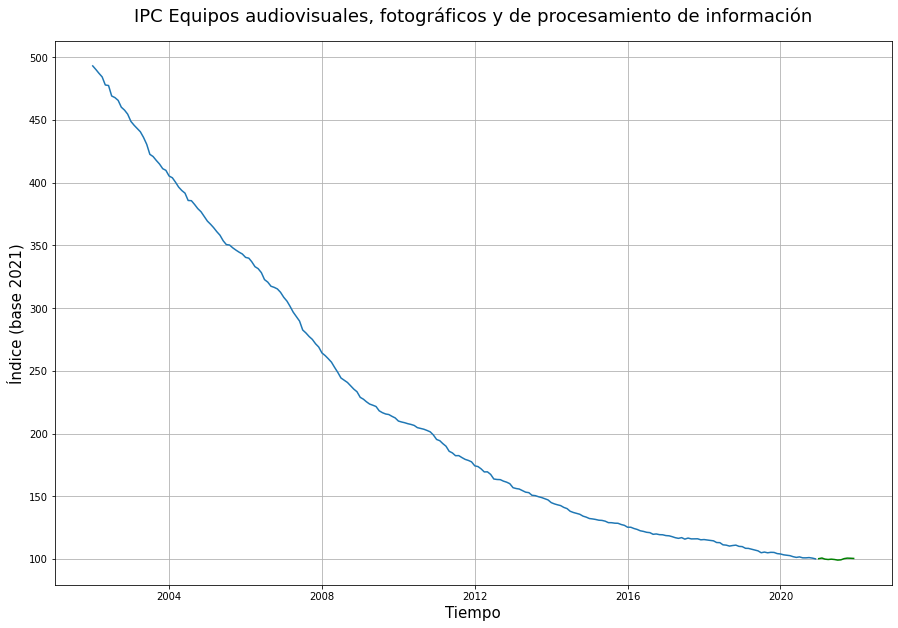

In [ ]:
#Seleccionamos la serie:
Serie_IPC_Tecnología = entrenamiento_datos_IPC_Tecnologia_hasta_2020[["IPC_Tecnologia"]]

#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_IPC_Tecnología)
plt.plot(test_datos_IPC_Tecnologia_2021[["IPC_Tecnologia"]], c="g")

#Título y ejes:
ax.set_title("IPC Equipos audiovisuales, fotográficos y de procesamiento de información", 
                  pad = 20, #Eleva el título, separándolo del contorno de la figura
                  fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Índice (base 2021)", fontsize=15);

Empleamos `auto_arima()`:

In [ ]:
ARIMA_Serie_IPC_Tecnología = pm.auto_arima(Serie_IPC_Tecnología,
                                           trace=True, #Para que nos salga todo el proceso que realiza internamente
                                           seasonal=True, #Especificamos que tiene estacionalidad
                                           m=12) #Periodicidad de la estacionalidad. En este caso, mensual

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=637.101, Time=1.66 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=882.555, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=722.652, Time=0.20 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=685.325, Time=0.27 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=686.026, Time=1.17 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=667.282, Time=0.40 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=638.978, Time=2.63 sec
 ARIMA(2,2,2)(1,0,2)[12]             : AIC=638.972, Time=2.50 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=715.889, Time=0.18 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=671.868, Time=1.45 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=650.806, Time=0.90 sec
 ARIMA(2,2,2)(2,0,2)[12]             : AIC=640.988, Time=4.70 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=635.857, Time=0.71 sec
 ARIMA(1,2,2)(0,0,1)[12]             : AIC=684.014, Time=0.40 sec
 ARIMA(1,2,2)(1,0,0)[12]         

In [ ]:
#Obtenemos el AIC:
ARIMA_Serie_IPC_Tecnología.aic()

633.8675031083973

In [ ]:
print(ARIMA_Serie_IPC_Tecnología.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  228
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood                -311.934
Date:                            Mon, 27 Jun 2022   AIC                            633.868
Time:                                    16:29:30   BIC                            650.970
Sample:                                         0   HQIC                           640.769
                                            - 228                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1778      0.057     -3.138      0.002      -0.289      -0.067
ma.L1         -0.7802      0.045   

Todos los coeficientes son estadísticamente significativos.

El modelo obtenido es un $ARIMA(1,2,1)(1,0,1)_{12}$:
\begin{align}
\Delta^2Y_t=-0,1778Y_{t-1}+a_t-0,7802a_{t-1}+0,9547Y_{t-12}-0,7184a_{t-12}
\end{align}

In [ ]:
ARIMA_Serie_IPC_Tecnología.resid().mean()

1.071232861199292

In [ ]:
#Test de la t para contrastar que la media de los residuos es cero:
stats.ttest_1samp(ARIMA_Serie_IPC_Tecnología.resid(), 0)

Ttest_1sampResult(statistic=0.441010686018822, pvalue=0.659624991255063)

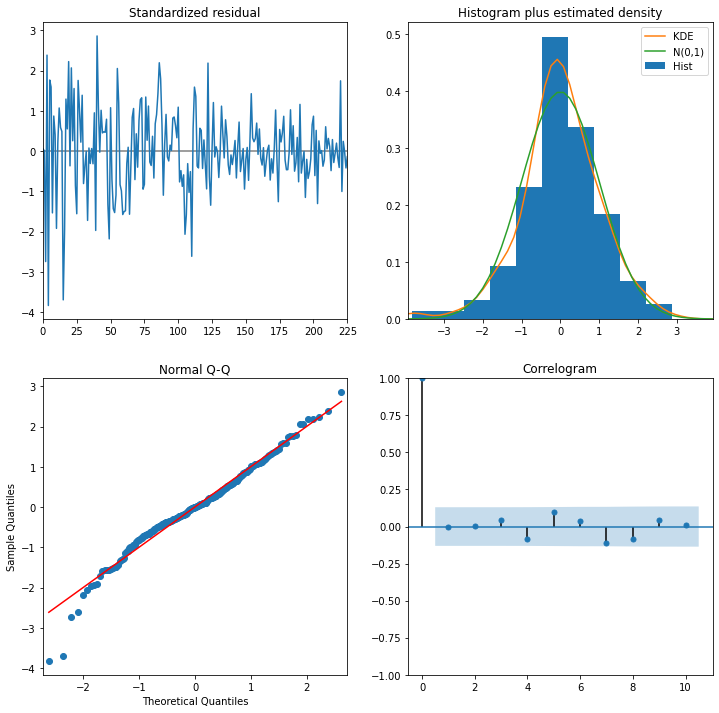

In [ ]:
Graficos = ARIMA_Serie_IPC_Tecnología.plot_diagnostics(figsize=(12,12))

Por otro lado, atendiendo a los contrastes y gráficos sobre los residuos, éstos tampoco se distribuyen como ruido blanco ya que su varianza no es constante.

Finalmente, pasamos a predecir el año 2021 y a compararlo con el 2021 real:

In [ ]:
#Predecimos el 2021 (12 meses) y el intervalo de confianza al 95% de las predicciones:
prediccion_2021_IPC_Tecnologia, confint_2021_IPC_Tecnologia = ARIMA_Serie_IPC_Tecnología.predict(n_periods = 12,  return_conf_int=True)
prediccion_2021_IPC_Tecnologia = pd.DataFrame(prediccion_2021_IPC_Tecnologia, index=test_datos_IPC_Tecnologia_2021.index)
confint_2021_IPC_Tecnologia = pd.DataFrame(confint_2021_IPC_Tecnologia, index=test_datos_IPC_Tecnologia_2021.index)
prediccion_2021_IPC_Tecnologia = pd.concat([prediccion_2021_IPC_Tecnologia, confint_2021_IPC_Tecnologia], axis=1)
prediccion_2021_IPC_Tecnologia.columns = [["Valores_Predichos", "Confint_Inferior", "Confint_Superior"]]
prediccion_2021_IPC_Tecnologia

,Valores_Predichos,Confint_Inferior,Confint_Superior
Meses,,,
2021-01-01,99.608799,97.769480,101.448118
2021-02-01,99.176936,96.520504,101.833368
2021-03-01,98.941687,95.423196,102.460178
2021-04-01,98.531132,94.131101,102.931163
2021-05-01,97.912448,92.594420,103.230476
2021-06-01,97.668032,91.393541,103.942522
2021-07-01,96.937044,89.666467,104.207621
2021-08-01,96.959350,88.653153,105.265547
2021-09-01,96.661967,87.281145,106.042789


Graficamos la serie real, la predicción y su intervalo de confianza:

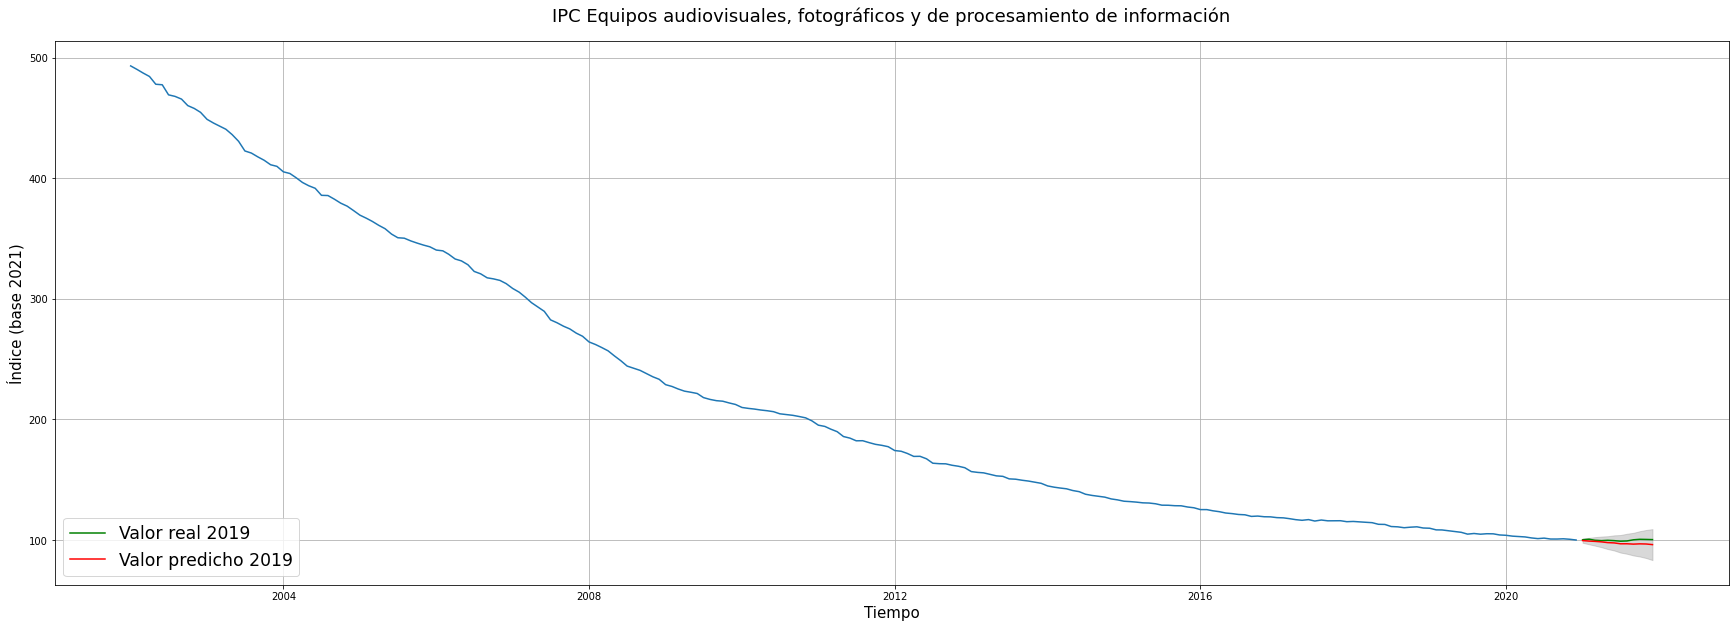

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(Serie_IPC_Tecnología)
plt.plot(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], label="Valor real 2019", c="g")
plt.plot(prediccion_2021_IPC_Tecnologia["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2021_IPC_Tecnologia.index,
                confint_2021_IPC_Tecnologia[0],
                confint_2021_IPC_Tecnologia[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("IPC Equipos audiovisuales, fotográficos y de procesamiento de información",
                  pad = 20, #Eleva el título, separándolo del contorno de la figura
                  fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Índice (base 2021)", fontsize=15)
plt.legend(loc="lower left", fontsize="xx-large");

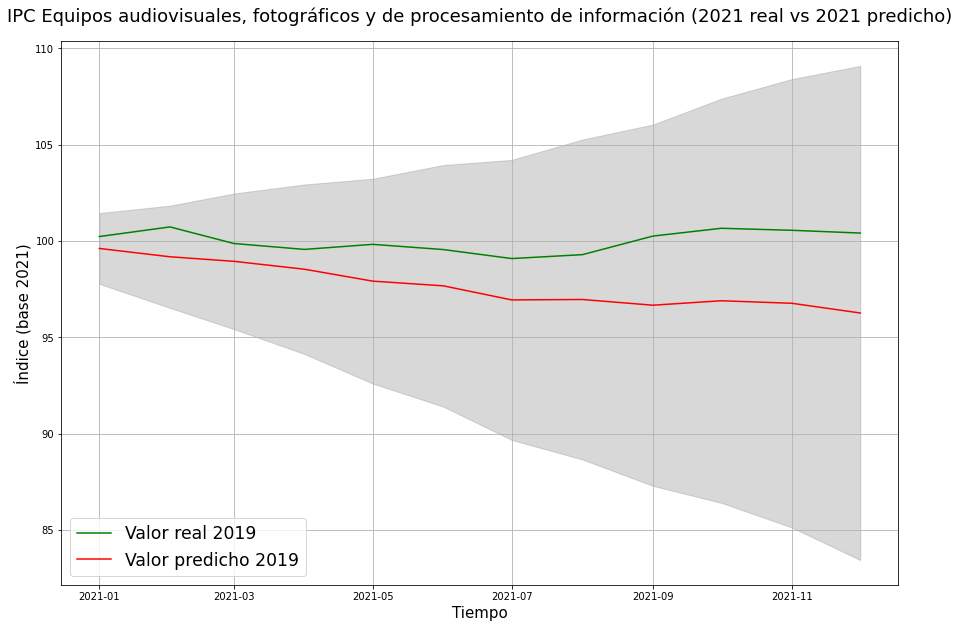

In [ ]:
#Creamos la figura:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.grid(True, zorder=0) #Añadimos una rejilla

#Graficamos la serie
plt.plot(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], label="Valor real 2019", c="g")
plt.plot(prediccion_2021_IPC_Tecnologia["Valores_Predichos"], label="Valor predicho 2019", c="r")
ax.fill_between(confint_2021_IPC_Tecnologia.index,
                confint_2021_IPC_Tecnologia[0],
                confint_2021_IPC_Tecnologia[1],
                color = "grey",
                alpha=0.3)

#Título y ejes:
ax.set_title("IPC Equipos audiovisuales, fotográficos y de procesamiento de información (2021 real vs 2021 predicho)", #IMPORTANTE: como no vamos a mostrar solo un mapa, el título debe ir cambiando conforme vamos utilizando nuestro widget
                  pad = 20, #Eleva el título, separándolo del contorno de la figura
                  fontdict={"fontsize":18}) 
ax.set_xlabel("Tiempo", fontsize=15)
ax.set_ylabel("Índice (base 2021)", fontsize=15)
plt.legend(loc="lower left", fontsize="xx-large");

En este caso, los valores predichos se encuentran por debajo de los reales. Esto se debe a que el periodo base del índice IPC se sitúa en 2021, por lo que los valores reales se sitúan en torno a 100 (base del índice), mientras que, siguiendo la tendencia a la baja de la serie, las predicciones también presentan una tendencia decreciente.

####**Comparación de los tres modelos vistos**

Para comparar la bondad del ajuste de la predicción a los datos reales en cada uno de los tres modelos obtenidos, vamos a emplear una serie de métricas:
* $R^2$: si el $R^2$ es alto, los valores reales y los predichos tienen una fuerte asociación.
* MAE (*Mean Absolute Error*): media entre las diferencias absolutas entre los valores predichos y los reales. Cuanto menor su valor, mejor será el modelo.
* MAPE (*Mean Absolute Percentage Error*): proporción de la media de las diferencias entre los valores predichos y los reales, dividido entre su verdadero valor. Cuanto menor su valor, mejor será el modelo.
* MSE (*Mean Squared Error*): media de los errores al cuadrado. Cuanto más cerca de cero esté su valor, mejor.
* RMSE (*Root Mean Squared Error*): raíz del MSE.

In [ ]:
#Métricas para la serie del PIB con datos NO ajustados:
test_datos_PIB_NO_ajustados_2019["Valores_Predichos"] = prediccion_2019_PIB_NO_ajustado["Valores_Predichos"]
R2_ARIMA_Serie_PIB_NO_ajustado = skmet.r2_score(test_datos_PIB_NO_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_NO_ajustados_2019["Valores_Predichos"])
MAE_ARIMA_Serie_PIB_NO_ajustado = skmet.mean_absolute_error(test_datos_PIB_NO_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_NO_ajustados_2019["Valores_Predichos"])
MAPE_ARIMA_Serie_PIB_NO_ajustado = skmet.mean_absolute_percentage_error(test_datos_PIB_NO_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_NO_ajustados_2019["Valores_Predichos"])
MSE_ARIMA_Serie_PIB_NO_ajustado = skmet.mean_squared_error(test_datos_PIB_NO_ajustados_2019["PIB(Millones_de_euros)"],test_datos_PIB_NO_ajustados_2019["Valores_Predichos"], squared=True)
RMSE_ARIMA_Serie_PIB_NO_ajustado = skmet.mean_squared_error(test_datos_PIB_NO_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_NO_ajustados_2019["Valores_Predichos"], squared=False)

In [ ]:
#Métricas para la serie del PIB con datos SÍ ajustados:
test_datos_PIB_SI_ajustados_2019["Valores_Predichos"] = prediccion_2019_PIB_SI_ajustado["Valores_Predichos"]
R2_ARIMA_Serie_PIB_SI_ajustado = skmet.r2_score(test_datos_PIB_SI_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_SI_ajustados_2019["Valores_Predichos"])
MAE_ARIMA_Serie_PIB_SI_ajustado = skmet.mean_absolute_error(test_datos_PIB_SI_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_SI_ajustados_2019["Valores_Predichos"])
MAPE_ARIMA_Serie_PIB_SI_ajustado = skmet.mean_absolute_percentage_error(test_datos_PIB_SI_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_SI_ajustados_2019["Valores_Predichos"])
MSE_ARIMA_Serie_PIB_SI_ajustado = skmet.mean_squared_error(test_datos_PIB_SI_ajustados_2019["PIB(Millones_de_euros)"],test_datos_PIB_SI_ajustados_2019["Valores_Predichos"], squared=True)
RMSE_ARIMA_Serie_PIB_SI_ajustado = skmet.mean_squared_error(test_datos_PIB_SI_ajustados_2019["PIB(Millones_de_euros)"], test_datos_PIB_SI_ajustados_2019["Valores_Predichos"], squared=False)

In [ ]:
#Métricas para la serie del IPC Tecnología:
test_datos_IPC_Tecnologia_2021["Valores_Predichos"] = prediccion_2021_IPC_Tecnologia["Valores_Predichos"]
R2_ARIMA_Serie_IPC_Tecnologia = skmet.r2_score(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], test_datos_IPC_Tecnologia_2021["Valores_Predichos"])
MAE_ARIMA_Serie_IPC_Tecnologia = skmet.mean_absolute_error(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], test_datos_IPC_Tecnologia_2021["Valores_Predichos"])
MAPE_ARIMA_Serie_IPC_Tecnologia = skmet.mean_absolute_percentage_error(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], test_datos_IPC_Tecnologia_2021["Valores_Predichos"])
MSE_ARIMA_Serie_IPC_Tecnologia = skmet.mean_squared_error(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"],test_datos_IPC_Tecnologia_2021["Valores_Predichos"], squared=True)
RMSE_ARIMA_Serie_IPC_Tecnologia = skmet.mean_squared_error(test_datos_IPC_Tecnologia_2021["IPC_Tecnologia"], test_datos_IPC_Tecnologia_2021["Valores_Predichos"], squared=False)

In [ ]:
Medidas = pd.DataFrame()
Medidas["Medidas"] = ["R2", "MAE", "MAPE", "MSE", "RMSE"]
Medidas["PIB NO ajustado"] = [R2_ARIMA_Serie_PIB_NO_ajustado, MAE_ARIMA_Serie_PIB_NO_ajustado, MAPE_ARIMA_Serie_PIB_NO_ajustado, MSE_ARIMA_Serie_PIB_NO_ajustado, RMSE_ARIMA_Serie_PIB_NO_ajustado]
Medidas["PIB SI ajustado"] = [R2_ARIMA_Serie_PIB_SI_ajustado, MAE_ARIMA_Serie_PIB_SI_ajustado, MAPE_ARIMA_Serie_PIB_SI_ajustado, MSE_ARIMA_Serie_PIB_SI_ajustado, RMSE_ARIMA_Serie_PIB_SI_ajustado]
Medidas["IPC Tecnología"] =  [R2_ARIMA_Serie_IPC_Tecnologia,  MAE_ARIMA_Serie_IPC_Tecnologia,  MAPE_ARIMA_Serie_IPC_Tecnologia,  MSE_ARIMA_Serie_IPC_Tecnologia,  RMSE_ARIMA_Serie_IPC_Tecnologia ]
Medidas.set_index("Medidas", inplace=True)
Medidas.head()

,PIB NO ajustado,PIB SI ajustado,IPC Tecnología
Medidas,,,
R2,0.981279,0.313510,-23.142283
MAE,1.243618,2.074751,2.307479
MAPE,0.004017,0.006653,0.023050
MSE,1.720517,4.913689,6.715623
RMSE,1.311685,2.216684,2.591452


Como podemos comprobar al atender a todas las métricas, el modelo del PIB entrenado con los datos NO ajustados es el que mejores predicciones consigue.
